<sub>&copy; 2021-present Neuralmagic, Inc. // [Neural Magic Legal](https://neuralmagic.com/legal)</sub> 

# Running YOLO Models on the DeepSparse Engine

In [this blog post](https://neuralmagic.com/blog/benchmark-yolov3-on-cpus-with-deepsparse/) the Neural Magic team describes how achieving real-time inference speeds on [Ultralytic's YOLOv3](https://github.com/ultralytics/yolov5) using CPUs is possible. This notebook provides a step-by-step walkthrough for using the [DeepSparse](https://github.com/neuralmagic/deepsparse) Engine to attain and benchmark these speeds.

This notebook runs pre-sparsified models downloaded from the [SparseZoo](https://github.com/neuralmagic/sparsezoo). For information on creating custom sparsified YOLO models with [SparseML](https://github.com/neuralmagic/sparseml), check out the [SparseML-Ultralytics integration documentation](https://github.com/neuralmagic/sparseml/blob/main/integrations/ultralytics/README.md).


In this notebook, you will:
- Compile a model with the DeepSparse Engine
- Use the DeepSparse Engine to run a sample inference with YOLOv3 and annotate the output
- Run benchmarks of YOLOv3 on the DeepSparse Engine

## Setting Up
This notebook depends on other files from SparseML's Ultralytics integration examples as well as Ultralytic's yolov5 repo.  Run the following to start this notebook, and make sure this notebook is in the yolov5 directory.

```bash
# clone
git clone https://github.com/ultralytics/yolov5.git
git clone https://github.com/neuralmagic/sparseml.git

# copy example files
cd yolov5
cp ../sparseml/integrations/ultralytics/deepsparse/* .

# install dependencies
pip install sparseml[torchvision] deepsparse
pip install -r requirements.txt
```

## SparseZoo Stubs
[SparseZoo](https://github.com/neuralmagic/sparsezoo) stubs refer to models and SparseML recipes that are stored in the SparseZoo. They can be used to easily access these files through the `sparsezoo.Zoo` helper class, or even to load these models directly into DeepSparse.

The following cell defines SparseZoo stubs for three different models:
* *base*: YOLOv3-SPP baseline dense
* *pruned*: YOLOv3-SPP pruned to 88% sparsity
* *pruned_quant*: YOLOv3-SPP pruned to 83% sparsity and quantized with INT8 quantization

These stubs can be easily used for inference and benchmarking.

In [1]:
BASE_STUB = "zoo:cv/detection/yolo_v3-spp/pytorch/ultralytics/coco/base-none"
PRUNED_STUB = "zoo:cv/detection/yolo_v3-spp/pytorch/ultralytics/coco/pruned-aggressive_97"
PRUNED_QUANT_STUB = "zoo:cv/detection/yolo_v3-spp/pytorch/ultralytics/coco/pruned_quant-aggressive_94"

## Inference
In the following cells, you will download some sample images from the SparseZoo, compile a model with the DeepSparse Engine, and use this model to perform a sample inference.

The basic flow for using the DeepSparse Engine for inference is just two steps: compiling a model and running a forward pass with the model:

```python
from deepsparse import compile_model
import numpy

# compile
model = compile_model(MODEL_PATH, batch_size=BATCH_SIZE)

# inference
outputs = model([numpy.random.randn(1, 3, 640, 640)])
```

### Download Sample Images
The following cell uses a helper function to download sample images from the SparseZoo:

In [2]:
from benchmark import load_images

images, original_images = load_images(None, (640, 640))

downloading...:   0%|          | 0/12201941 [00:00<?, ?it/s]

### Compile Model
The following cell compiles a DeepSparse model from the YOLOv3 pruned SparseZoo stub.  To use a different YOLO model, replace `sample_model_path` with a different stub path or the path to a local ONNX model file. This example does require that the model expects 640,640 sized image inputs.

In [3]:
from deepsparse import compile_model

sample_model_path = PRUNED_STUB  # replace with file path or stub of choice
model = compile_model(sample_model_path, batch_size=1)

downloading...:   0%|          | 0/251915109 [00:00<?, ?it/s]

### Inference
The following cell runs pre-processing, inference, post-processing, and NMS on a sample image.  Try changing the `SAMPLE_IMAGE_IDX` (can be 0-19) to see different inputs.

In [4]:
import numpy
from deepsparse_utils import YoloPostprocessor, postprocess_nms

SAMPLE_IMAGE_IDX = 0

sample_image = images[SAMPLE_IMAGE_IDX]
sample_image = sample_image.reshape(1, *sample_image.shape)
if sample_model_path != PRUNED_QUANT_STUB:  # preprocess images for non-quantized
    sample_image = sample_image.astype(numpy.float32) / 255.0
sample_batch = [numpy.ascontiguousarray(sample_image)]

outputs = model(sample_batch)
outputs = YoloPostprocessor().pre_nms_postprocess(outputs)
outputs = postprocess_nms(outputs)

### Annotate
The following cell visualizes the output from DeepSparse by annotating the original image with the returned bounding boxes and classes.

Matplotlib is building the font cache; this may take a moment.


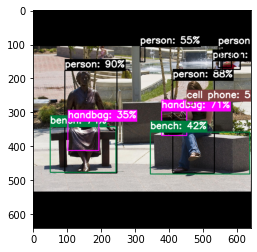

In [5]:
import matplotlib.pyplot as plt
from deepsparse_utils import annotate_image

%matplotlib inline

annotated_image = annotate_image(original_images[SAMPLE_IMAGE_IDX], outputs[0], 0.35)
plt.imshow(annotated_image)

## Benchmark
The following cells run benchmarks of the base, pruned, and pruned-quantized models.  Benchmark times are end-to-end and include pre-processing, inference, post-processing and NMS.  The defualt setting is a "real-time" batch-size 1 example with the maximum number of CPU cores available used. To try benchmarking other deployment scenarios, edit the `BATCH_SIZE`, `NUM_CORES`, and `IMAGE_SIZE` variables.

The benchmarking function provided below calls into the `benchmark.py` script that is also provided in this examples directory.  For best results, that script should be used as processes in the Jupyter Notebook may interfere with the benchmark.

In [7]:
import os
from benchmark import benchmark_yolo, parse_args

BATCH_SIZE = 1
NUM_CORES = None  # set to integer to use
IMAGE_SIZE = ["640", "640"]

os.environ["NM_BIND_THREADS_TO_CORES"] = "1"  # bind threads to cores


def benchmark(model_path, quantized=False):
    benchmark_args = [
        model_path,
        f"--batch-size={BATCH_SIZE}",
        "--image-shape",
        *IMAGE_SIZE,
    ]
    if NUM_CORES:
        benchmark_args.append("--num-cores={NUM_CORES}")
    if quantized:
        benchmark_args.append("--quantized-inputs")
    benchmark_args = parse_args(benchmark_args)
    benchmark_yolo(benchmark_args)

### Base Model

In [8]:
benchmark(BASE_STUB)

model with stub zoo:cv/detection/yolo_v3-spp/pytorch/ultralytics/coco/base-none downloaded to /home/developer/.cache/sparsezoo/16fe8358-2e91-4b81-a1f2-df85bd1a9ac3/model.onnx


DecodeError: Error parsing message

### Pruned Model

In [9]:
benchmark(PRUNED_STUB)

model with stub zoo:cv/detection/yolo_v3-spp/pytorch/ultralytics/coco/pruned-aggressive_97 downloaded to /home/developer/.cache/sparsezoo/ebb5a310-7206-4d5e-b8c0-fbe52e469f2e/model.onnx
Compiling deepsparse model for /home/developer/.cache/sparsezoo/ebb5a310-7206-4d5e-b8c0-fbe52e469f2e/model.onnx
Engine info: deepsparse.engine.Engine:
	onnx_file_path: /home/developer/.cache/sparsezoo/ebb5a310-7206-4d5e-b8c0-fbe52e469f2e/model.onnx
	batch_size: 1
	num_cores: 4
	num_sockets: 1
	scheduler: Scheduler.default
	cpu_avx_type: avx2
	cpu_vnni: False
Loading dataset
Running for 25 warmup iterations and 80 benchmarking iterations


  0%|          | 0/80 [00:00<?, ?it/s]

Benchmarking complete. End-to-end results:
BenchmarkResults:
	items_per_second: 0.9363367648282417
	ms_per_batch: 1067.9918140172958
	batch_times_mean: 1.067991814017296
	batch_times_median: 1.0703707933425903
	batch_times_std: 0.06766547679634284
End-to-end per image time: 1067.9918140172958ms


### Pruned-Quantized Model

In [ ]:
benchmark(PRUNED_QUANT_STUB, quantized=True)

## Next Steps

Congratulations, you have created run a sample inference of YOLOv3 using the DeepSparse Engine and benchmarked its performance across various deployment settings. Next steps can include:
* Sparsify other models, or this model for other datasets using the SparseML-Ultralytics integration
* Try the other exmaples in this directory
* Learn more about [Neural Magic](https://github.com/neuralmagic) and [Ultralytic's](https://github.com/ultralytics) open-sourced repositories.